<a href="https://colab.research.google.com/github/yaniv256/workshops/blob/master/Notebooks/TF2_intro_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSM: Intro to TensorFlow 2

What is this workshop about?

1. The three APIs of TensorFlow 2
2. Airbnb price regressions
3. Getting insights from gradients

### How to run the notebook?

* The notebook can be run on Google Colab or a Jupyter Notebook 
* https://github.com/yaniv256/workshops/blob/master/notebooks/TF2-intro-Airbnb.ipynb
* Or web search Colab, go to the `Github` tab, enter `yaniv256`, pick the `workshops` repository, and pick the `TF2-intro-Airbnb.ipynb` notebook.

## Why TensorFlow 2?

TF2: "We will add your biological and technological distinctiveness to our own... Resistance is futile."
* Freely copied the best of PyTorch
* Keras was assimilated
* Still most popular (according to [Google trends](https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=TensorFlow,PyTorch,Keras))


## The three APIs

1. Sequencial: when all you need is a stack of layers
2. Functional: when you want to connect layers in whatever way
3. Subclassing: Object Oriented + connect on input

And there's also TensorFlow itself - good for any symbolic computation.

### Example: Sequencial API

In [0]:
import tensorflow.keras as keras

def build_model_sequential(input_shape, activation='relu', width=128):

    model = keras.Sequential()
    model.add(keras.layers.Dense(width, activation=activation,
                                 input_shape=input_shape))
    model.add(keras.layers.Dense(width, activation=activation))
    model.add(keras.layers.Dense(1))

    return model

build_model_sequential((15,))

### Example: Functional API

In [0]:
import tensorflow.keras as keras

def build_model_functional(input_shape, activation='relu', width=128):

    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Dense(width, activation=activation)(inputs)
    x = keras.layers.Dense(width, activation=activation)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

build_model_functional((15,))

### Example: Subclassing API

In [0]:
def build_model_subclassing(activation='relu', width=128):

    class MyModel(keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.dense1 = keras.layers.Dense(width, activation=activation)
            self.dense2 = keras.layers.Dense(width, activation=activation)
            self.out = keras.layers.Dense(1)

        def call(self, x):
            x = self.dense1(x)
            x = self.dense2(x)
            return self.out(x)

    model = MyModel()

    return model

build_model_subclassing()

<__main__.build_model_subclassing.<locals>.MyModel at 0x7f079b8bf278>

### Which API should you learn?

* Sequencial is good enough for most tasks
* Same code in Functional is just as short and no less clear

* If you want to build reusable objects, go for Subclassing
* Otherwise, Functional is as powerful and more readable

## Airbnb price regressions

* Predict a listings price based on its features
* Valuate listings
* Valuate locations

### Valuation vs. prediction

* Making a best prediction isn't the same as estimating value
* Many listings are overpriced
* Lots of reviews indicate price is low relative to listing value

## Insight from gradients

* What is the sensitivity of a prediction to each input?
* Which variables are most important?
* How to examine non-linearities and interactions?

Answers to all: gradients.

# Airbnb data

Data source: http://insideairbnb.com/index.html

## Load Twin Cities data

In [0]:
%%writefile airbnbloader.py
from collections import OrderedDict
import pandas as pd
from datetime import datetime
import numpy as np


def load(date='2019-06-02', location='united-states/mn/twin-cities-msa'):

    filename = (
        'http://data.insideairbnb.com/{}/{}/data/listings.csv.gz'.format(
            location, date))

    data = pd.read_csv(filename)

    data.price = data.price.apply(lambda x: float(x[1:].replace(',', '')))

    weekday = data.last_review.dropna().apply(
      lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
    weekday.name = 'last_review_weekday'
    data = data.join(weekday)

    days_since_last_review = data.last_review.dropna().apply(
        lambda x: (datetime.strptime(date, '%Y-%m-%d')
                   - datetime.strptime(x, '%Y-%m-%d')).days)
    days_since_last_review.name = 'days_since_last_review'
    data = data.join(days_since_last_review)

    features = data[[
        'price',
        'latitude',
        'longitude',
        'room_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'minimum_nights',
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month',
        'calculated_host_listings_count',
        'availability_30',
        'availability_365'
        ]]

    features.dropna(inplace=True)
    features = features[features.availability_365 != 0]
    features = features[features.availability_365 != 365]

    onehot_room_type = pd.get_dummies(features['room_type'])

    onehot_room_type.drop(['Private room'], axis=1, inplace=True)

    features = pd.concat([features, onehot_room_type], axis=1)

    targets = features['price'].apply(lambda x: np.log(x+1))

    features.drop(['price', 'room_type'], axis=1, inplace=True)

    return features, targets, data


def all_value_counts(data, n=5):

    return OrderedDict(
        (field,
         dict(n=len(set(data[field])),
              top=list(zip(
                  data[field].value_counts().head(n).index,
                  data[field].value_counts().head(n).values))))
        for field in data.columns)

Overwriting airbnbloader.py


Some dates that are available for `location='united-states/mn/twin-cities-msa':`
* Last June: date='2019-06-02'
* Last January: date='2020-01-04'
* Most recent: date='2020-04-14'

In [0]:
import importlib
import warnings
import airbnbloader

warnings.filterwarnings('ignore')

features, targets, data = airbnbloader.load(
    location='united-states/mn/twin-cities-msa',
    date='2019-06-02'
)

features.shape, targets.shape, data.shape

((2951, 15), (2951,), (6607, 108))

In [0]:
features.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  45.00886  -93.23407  ...                1            0
1  44.94566  -93.35721  ...                0            0
2  44.91878  -93.23038  ...                0            0
3  44.92053  -93.35049  ...                1            0
7  44.92136  -93.22873  ...                0            0

[5 rows x 15 columns]

Split to train and test data sets.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    targets,
    test_size=0.25,
    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2213, 15), (738, 15), (2213,), (738,))

## Map listings

In [0]:
%%writefile mapairbnb.py
import plotly.graph_objects as go


def plot(data, features, color_by, color_title, zoom=10, hover=True,
         center=dict(lat=44.981944, lon=-93.269167)):

    data_ = data.loc[features.index]

    if hover:
        text = [
            '{}  <br> ${}'.format(data_.name[i], data_.price[i])
            + '<br>Number of reviews: {}<br>'.format(
                data_.number_of_reviews[i])
            + ' <a href="{}">link</a>'.format(
                data_.listing_url[i])
            + '<br>Availability: {}'.format(data_.availability_365[i])
            + '<br>Days since last review: {}'.format(
                features.days_since_last_review[i])
            + '<br>Accommodates: {}'.format(features.accommodates[i])
            for i in data_.index]
    else:
        text = ''

    fig = go.Figure(go.Scattermapbox(
        lat=features.latitude,
        lon=features.longitude,
        mode='markers',
        text=text,
        hoverinfo='text',
        marker=dict(color=color_by, colorscale='rainbow',
                    colorbar=dict(title=color_title), size=9),
        ))

    fig.update_layout(
        hovermode='x',
        hoverdistance=20,
        mapbox_style='white-bg',
        autosize=False,
        width=800,
        height=400,
        mapbox_layers=[{
            'below': 'traces', 'sourcetype': 'raster',
            'source': ['https://basemap.nationalmap.gov/arcgis/rest/services/'
                       + 'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}']}],
        mapbox=dict(bearing=0, center=center, pitch=0, zoom=zoom),
        )

    fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

    return fig

Overwriting mapairbnb.py


In [0]:
import mapairbnb

mapairbnb.plot(data, features, color_by=targets, color_title='Log price')

# OLS Regression
Let's run an OLS regression as a benchmark

In [0]:
import statsmodels.api as sm
import pandas as pd

X_train_with_const = sm.add_constant(
    pd.DataFrame(X_train, columns=features.columns))
X_test_with_const = sm.add_constant(
    pd.DataFrame(X_test, columns=features.columns))

results = sm.OLS(y_train, X_train_with_const).fit(cov_type='HC0')

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     225.5
Date:                Tue, 19 May 2020   Prob (F-statistic):               0.00
Time:                        21:13:01   Log-Likelihood:                -1952.4
No. Observations:                2213   AIC:                             3937.
Df Residuals:                    2197   BIC:                             4028.
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Valuate listings

* Lots of reviews indicate lower prices relative to the value
* We need to fix the review variables on some constant
* Let's use the median.

In [0]:
%%writefile fixcolumns.py
import numpy as np
import pandas as pd


def fix(data, fix_columns, fix_on):

    all_fixed = pd.DataFrame(
        np.tile(fix_on, (len(data), 1)),
        columns=data.columns)

    all_fixed.index = data.index

    fixed_data = data.copy()

    fixed_data[fix_columns] = all_fixed[fix_columns]

    return fixed_data


Overwriting fixcolumns.py


In [0]:
import fixcolumns

fix_reviews = fixcolumns.fix(
    data=features,
    fix_columns=[
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month'],
    fix_on=features.median().values
    )

fix_reviews.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  45.00886  -93.23407  ...                1            0
1  44.94566  -93.35721  ...                0            0
2  44.91878  -93.23038  ...                0            0
3  44.92053  -93.35049  ...                1            0
7  44.92136  -93.22873  ...                0            0

[5 rows x 15 columns]

Now we can use the review-constant listings to estimate the "right" price for listings and compare that to what it is listed for. 

In [0]:
ols_predicted = results.predict(
    sm.add_constant(fix_reviews, has_constant='add'))
overpriced = targets-ols_predicted
mapairbnb.plot(
    data, features, color_by=overpriced, color_title='Diff log price')

## Location, location, location!

To see the effect of location we need to hold everything else fixed. One approach is to pick the median value for everything other than location and use that to make predictions.

In [0]:
location_only = fixcolumns.fix(
    data=features,
    fix_columns=features.columns[2:],
    fix_on=features.describe().loc['50%'].values
    )

location_only.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  45.00886  -93.23407  ...              1.0          0.0
1  44.94566  -93.35721  ...              1.0          0.0
2  44.91878  -93.23038  ...              1.0          0.0
3  44.92053  -93.35049  ...              1.0          0.0
7  44.92136  -93.22873  ...              1.0          0.0

[5 rows x 15 columns]

Fixing all but location we can map the value of a location.

In [0]:
import numpy as np

location_predicted = results.predict(
    sm.add_constant(location_only, has_constant='add'))

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=7, hover=False)

This clearly fails. A linear model can only generate linear maps, but location isn't linear.

# TensorFlow II
* Coding in TensorFlow is very similar to coding with NumPy 
* Just use TensorFlow functions
* Unlike NumPy, TensorFlow keeps track of derivatives

## Adding a custom metric: $R^2$


To get a feel for pure TensorFlow let's write a TensorFlow function calculating $R^2$. Recall that 

$$R^2=1-\frac{\Sigma (y-\hat{y})^2}{\Sigma (y-\bar{y})^2}$$

TensorFlow doesn't provide an $R^2$ metric, most likely because

1. $R^2$ computed on each batch is a downward biased estimate of whole epoch $R^2$
2. Average batch $R^2$ will not equal whole epoch $R^2$

We will use the usual small sample bias correction

$$\tilde{R}^2=1-\frac{\Sigma (y-\hat{y})^2}{\frac{n}{n-1}\Sigma (y-\bar{y})^2}$$

In [0]:
%%writefile tf_r2.py
import tensorflow as tf

def R_squared(y_true, y_pred):

    # TensorFlow uses 'float32' as the default type and often raises an error
    # when you mix 'float32' and 'float64' in calculations. Since 'float64' is
    # the Python default, this happens a lot. Casting everything to 'float32' 
    # is your best option.
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')

    residual_var = tf.reduce_sum(tf.square(y_true - y_pred))
    total_var = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

    # Adjust for small batch bias
    n = tf.cast(tf.size(y_true), 'float32')
    total_var *= n/(n-1)

    return (1.0 - residual_var/total_var)

Writing tf_r2.py


Tensorflow functions produce tensors which are only computed when you call `.numpy()` on them.

In [0]:
import numpy as np
import tf_r2

OLS_r2 = dict(
    Train=tf_r2.R_squared(
        y_train,
        results.predict(X_train_with_const)
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test,
        results.predict(X_test_with_const)
        ).numpy()
    )

pd.DataFrame(pd.Series(OLS_r2), columns=['OLS R2']).transpose()

Train      Test
OLS R2  0.601956  0.540067

## Add dropout
To boost performance a little we can add dropout regularization layers. Here's how in each of the three APIs.

In [0]:
%%writefile simple_dnn.py

import tensorflow.keras as keras

# The sequencial API: create one layer at a time and add it to the model. We 
# don't have to provide the shape of the input, but if we don't the 
# construction of the model will be delayed until the first call to `fit()`


def build_model_sequential(
        input_shape=None,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    model = keras.Sequential()
    for i in range(n_hidden):
        if i == 0 and input_shape:
            model.add(keras.layers.Dense(width,
                                         activation=activation,
                                         input_shape=input_shape))
        else:
            model.add(keras.layers.Dense(width, activation=activation))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1))

    return model

# The functional API: create layers and apply them, all before input. We have
# to provide the shape of the input to `keras.Input`.


def build_model_functional(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(n_hidden):
        x = keras.layers.Dense(width, activation=activation)(x)
        x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# The subclassing API: create layers and store them, apply only on input. We 
# don't need to provide the shape of the input.


def build_model_subclassing(
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    class MyModel(keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.dense = []
            self.dropout = []
            for i in range(n_hidden):
                self.dense.append(
                    keras.layers.Dense(
                        width, activation=activation))
                self.dropout.append(keras.layers.Dropout(dropout))
            self.out = keras.layers.Dense(1)

        def call(self, x):
            for i in range(n_hidden):
                x = self.dense[i](x)
                x = self.dropout[i](x)
            return self.out(x)

    model = MyModel()

    return model

Writing simple_dnn.py


You can't ask for `summary()` when not providing input_shape as the layers only 
get built on the first input.

In [0]:
import simple_dnn

simple_dnn.build_model_sequential(X_train.shape[1:]).summary()

# This will work:
# simple_dnn.build_model_functional(X_train.shape[1:]).summary()

# This will not:
# keras_dnn.build_model_sequential().summary()
# keras_dnn.build_model_subclassing().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________


## Standard scale the features
Neural networks perform much better on scaled inputs.

In [0]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.mean(), X_test_scaled.mean())
print(X_train_scaled.std(), X_test_scaled.std())

2.6254441709490915e-15 0.012337521054669603
1.0 1.040016761260583


## Training 
Training has the same interface for all APIs. Here we'll
* Minimize Mean Square Error (MSE) using Stocastic Gradient Decent
* Keep track of $R^2$
* Use only full batchs ($R^2$ needs this)
* Stop after no improvment on validation for 30 epochs
* Get back to best performing model at the end

In [0]:
%%writefile train_dnn.py

import tensorflow.keras as keras
from tf_r2 import R_squared

def train(model, X_train, y_train, X_test, y_test, 
          optimizer=keras.optimizers.SGD(0.025),
          batch_size = 32, epochs=1000, patience=30):
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[R_squared])

    X_train = X_train[:-(len(X_train) % batch_size)]
    y_train = y_train[:-(len(y_train) % batch_size)]
    X_test = X_test[:-(len(X_test) % batch_size)]
    y_test = y_test[:-(len(y_test) % batch_size)]

    early_stopping = keras.callbacks.EarlyStopping(
        patience=patience,
        restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    return history


Writing train_dnn.py


In [0]:
import train_dnn

# You can pick any of the following
# model = simple_dnn.build_model_sequential()
# model = simple_dnn.build_model_sequential(X_train.shape[1:])
model = simple_dnn.build_model_functional(X_train.shape[1:])
# model = simple_dnn.build_model_subclassing()

history = train_dnn.train(model, X_train_scaled, y_train,
                          X_test_scaled, y_test)

Epoch 1/1000
69/69 [==============================] - 0s 4ms/step - loss: 1.6674 - R_squared: -1.0457 - val_loss: 0.6401 - val_R_squared: 0.1574
Epoch 2/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.6256 - R_squared: 0.2318 - val_loss: 0.4347 - val_R_squared: 0.4201
Epoch 3/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.5255 - R_squared: 0.3639 - val_loss: 0.3902 - val_R_squared: 0.4959
Epoch 4/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4789 - R_squared: 0.4197 - val_loss: 0.3734 - val_R_squared: 0.5120
Epoch 5/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4467 - R_squared: 0.4608 - val_loss: 0.4011 - val_R_squared: 0.4828
Epoch 6/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4473 - R_squared: 0.4763 - val_loss: 0.3473 - val_R_squared: 0.5523
Epoch 7/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3978 - R_squared: 0.5239 - val_loss: 0.3582 - val_R_squared

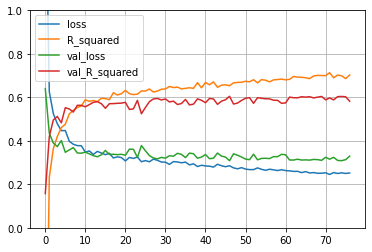

In [0]:
pd.DataFrame(history.history).plot(ylim=(0, 1), grid=True)

## Performance

In [0]:
import tf_r2

DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model.predict(X_train_scaled).flatten()
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test, model.predict(X_test_scaled).flatten()
        ).numpy()
    )

pd.DataFrame([OLS_r2, DNN_r2], index=['OLS R2', 'DNN R2'])

Train      Test
OLS R2  0.601956  0.540067
DNN R2  0.725528  0.613290

## Valuate listings

In [0]:
dnn_predicted = model.predict(scaler.transform(fix_reviews)).flatten()
overpriced = targets-dnn_predicted
mapairbnb.plot(data, features, color_by=overpriced, color_title='Diff log price')

## Location, location, location, again!



In [0]:
location_predicted = model.predict(scaler.transform(location_only)).flatten()

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=8, hover=False)

Still a faliure but at least it's not linear anymore.

# Insight from gradients

Real easy to compute derivatives in TF2
* Define inputs as TF variables
* Do TF calculations under a `with tf.GradientTape() as tape:`
* Call `tape.gradient(outputs, inputs)`

But use `model()` instead of `model.predict()`

In [0]:
import tensorflow as tf

X = tf.Variable(features.values, dtype='float32')

with tf.GradientTape() as tape:
    X_std = (X-scaler.mean_) / scaler.scale_
    predictions = model(X_std)   # model.predict() is for non-TF inputs

dnn_coefs = tape.gradient(predictions, X).numpy()

dnn_coefs = pd.DataFrame(dnn_coefs,
                         columns=features.columns,
                         index=features.index)
dnn_coefs.head()

latitude  longitude  ...  Entire home/apt  Shared room
0 -0.566718   0.554624  ...         0.674228    -1.034904
1 -0.401014   0.191109  ...         0.396923    -1.845068
2 -0.607458   0.575160  ...         0.316264    -1.324180
3  0.292898   0.033569  ...         0.777317    -1.891021
7 -0.558203  -0.046267  ...         0.730157    -2.841786

[5 rows x 15 columns]

## Compare with OLS
* Coefficients are different for every observation 
* Avarage is still comparable to OLS

In [0]:
ols_coef = pd.Series(results.params[1::], name='OLS_coef')

dnn_mean_coef = pd.Series(dnn_coefs.mean(axis=0),
                          index=features.columns,
                          name='DNN_mean_grad')

pd.DataFrame([ols_coef, dnn_mean_coef]).transpose()

OLS_coef  DNN_mean_grad
latitude                       -0.135648      -0.101971
longitude                       0.058068       0.045855
accommodates                    0.046694       0.043020
bathrooms                       0.195347       0.159187
bedrooms                        0.112668       0.073014
beds                           -0.022113       0.039917
minimum_nights                 -0.005416      -0.011969
days_since_last_review          0.000704       0.000418
number_of_reviews              -0.000174      -0.002336
reviews_per_month              -0.068020      -0.122962
calculated_host_listings_count  0.002911      -0.006169
availability_30                 0.013167       0.007152
availability_365               -0.000052       0.000270
Entire home/apt                 0.768210       0.666180
Shared room                    -0.516085      -1.339079

## Variable Importance
For each observation we can estimate the importance of each variable by multiplying the coefficients by the deviation of inputs from their mean.

In [0]:
# Approximate each variable's effect by multiplying its absolute deviation 
# from its mean by the sensitivity of prediction to that variable.
abs_effect = (dnn_coefs * (features-features.mean())).abs()

# Compute per-row sum and reshape it to a vertical vector
abs_effect_sum = np.reshape(abs_effect.sum(axis=1).values, (len(features), 1))

# Divide by the sum so that effects sum to 1
per_obs_importance = abs_effect / abs_effect_sum

per_obs_importance.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  0.025335   0.021496  ...         0.388284     0.018480
1  0.015241   0.020067  ...         0.272100     0.021092
2  0.056060   0.022962  ...         0.301585     0.021056
3  0.012478   0.002171  ...         0.189281     0.014278
7  0.016119   0.000639  ...         0.227184     0.014744

[5 rows x 15 columns]

Averaging across observations we have a measure of variable importance.

In [0]:
mean_abs_effect = per_obs_importance.mean().sort_values(ascending=False)

pd.DataFrame(
    mean_abs_effect/mean_abs_effect.sum(),
    columns=['Variable Importance'])

Variable Importance
Entire home/apt                            0.232723
reviews_per_month                          0.115235
accommodates                               0.087285
bathrooms                                  0.073099
bedrooms                                   0.065378
number_of_reviews                          0.065282
availability_30                            0.057440
availability_365                           0.052440
beds                                       0.051443
calculated_host_listings_count             0.047320
days_since_last_review                     0.042230
longitude                                  0.041465
latitude                                   0.034261
minimum_nights                             0.019046
Shared room                                0.015353

## Error analysis

In [0]:
%%writefile erranalysis.py

import pandas as pd
import numpy as np


def table(predictions, targets, features, data, per_obs_importance, dnn_coefs,
          mean_abs_effect):

    pred = pd.Series(predictions.numpy().flatten(),
                     index=features.index,
                     name='pred')

    err = (pred - targets).sort_values()
    err.name = 'log pred - log price'

    error_analysis = (
        features.loc[err.index]
        .join(per_obs_importance.loc[err.index], rsuffix='_importance')
        .join(dnn_coefs.loc[err.index], rsuffix='_coef')
        )

    col = []
    for index in mean_abs_effect.index:
        col.append(index + '_importance')
        col.append(index + '_coef')
        col.append(index)
    col

    error_analysis = error_analysis.reindex(col, axis=1)
    error_analysis = (
        pd.DataFrame(data.name[err.index])
        .join('<a href="' + data.listing_url[err.index] + '">link</a>')
        .join(pred[err.index].apply(np.exp))
        .join(targets[err.index].apply(np.exp))
        .join(error_analysis)
        )

    return error_analysis


Writing erranalysis.py


In [0]:
from IPython.display import HTML
import erranalysis

error_analysis = erranalysis.table(
    predictions, targets, features, data, per_obs_importance, dnn_coefs,
    mean_abs_effect)

HTML(error_analysis.head().to_html(escape=False))

In [0]:
HTML(error_analysis.tail().to_html(escape=False))

## Explore non-linearity

In [0]:
%%writefile plotcoefs.py
import matplotlib.pyplot as plt


def plot_coefs_by_self(features, coefs, ols_results):

    plt.style.use('seaborn-whitegrid')

    for i, field in enumerate(features.columns):

        plt.scatter(
            x=features[field],
            y=coefs[field],
            alpha=0.05)

        plt.plot([features.min()[field], features.max()[field]],
                 [0, 0], '--', color='grey')

        # OLS coef
        plt.plot([features.min()[field], features.max()[field]],
                 [ols_results.params[field], ols_results.params[field]],
                 ':',
                 color='black'
                 )

        # OLS confidence intervals
        plt.fill_between(
            [features.min()[field], features.max()[field]],
            [ols_results.conf_int().loc[field, 0],
             ols_results.conf_int().loc[field, 0]],
            [ols_results.conf_int().loc[field, 1],
             ols_results.conf_int().loc[field, 1]],
            color='gray', alpha=0.2)

        plt.xlabel(field)
        plt.ylabel(field + ' coef')
        plt.legend(['Zero', 'OLS coef'])
        plt.show()


Writing plotcoefs.py


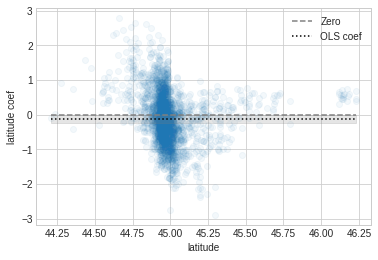

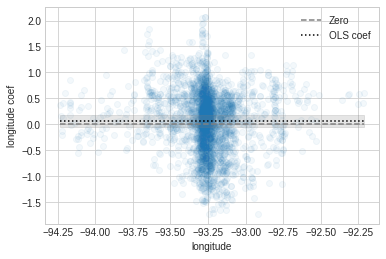

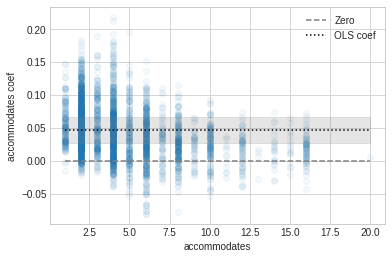

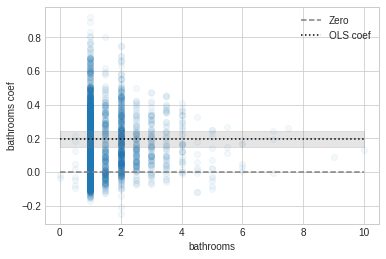

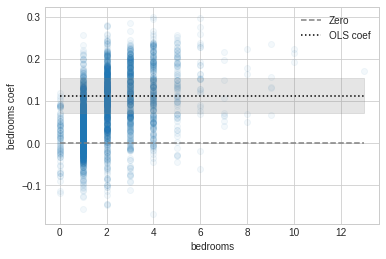

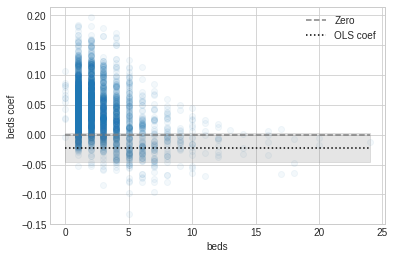

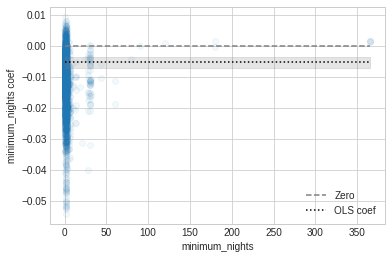

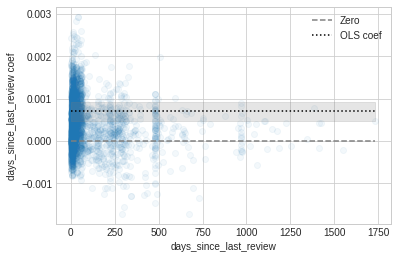

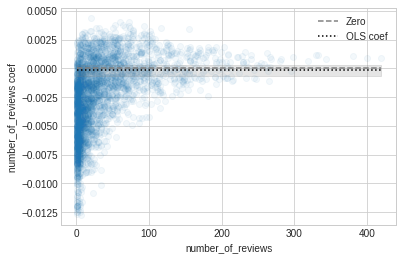

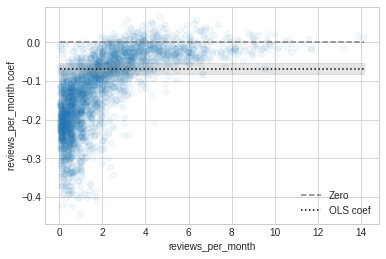

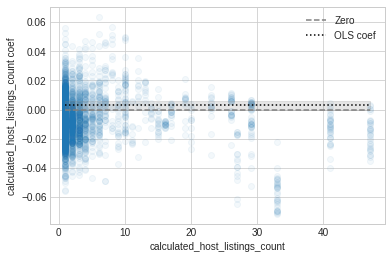

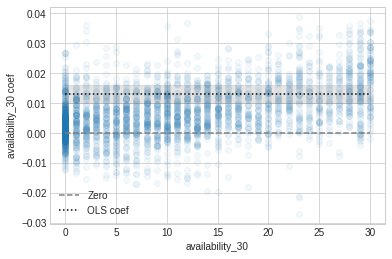

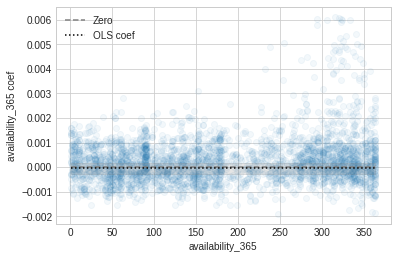

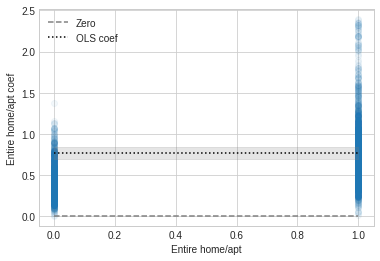

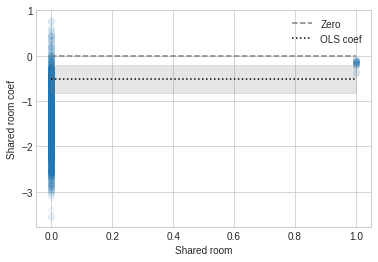

In [0]:
import plotcoefs

plotcoefs.plot_coefs_by_self(features, dnn_coefs, results)

## Location gradiants

If we think location coefficients as a 2-dimensional vector then its norm is a measure of effect of location on price.

In [0]:
location_sensitivity = dnn_coefs[['latitude', 'longitude']].apply(
    np.linalg.norm, axis=1)

mapairbnb.plot(data, features, color_by=location_sensitivity,
               color_title='location sensitivity', hover=False)

We see listings that are very sensitive mixed among ones that are not. So location sensitivity must be driven by features other than location itself. 

In [0]:
location_sensitivity.name = 'loc_sens'
with_loc_sens = features.join(location_sensitivity).sort_values(by='loc_sens')

# Pick a few listings from the high end of the sensitivity sort
# and use them to get a location valuation plot
for p in np.linspace(0.9, 1, 5):

    i = int(p * (len(features)-1))

    fixed_app = with_loc_sens.iloc[i, :].drop('loc_sens')
    print(with_loc_sens.iloc[i, :].drop(['latitude', 'longitude']))

    location_only = fixcolumns.fix(data=features,
                                   fix_columns=features.columns[2:],
                                   fix_on=fixed_app.values)

    location_predicted = model.predict(
        scaler.transform(location_only)).flatten()

    mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
                   color_title='Predicted price', hover=False, zoom=8).show()

accommodates                      16.000000
bathrooms                          2.000000
bedrooms                           8.000000
beds                              17.000000
minimum_nights                     2.000000
days_since_last_review             7.000000
number_of_reviews                  5.000000
reviews_per_month                  1.760000
calculated_host_listings_count     7.000000
availability_30                   20.000000
availability_365                  64.000000
Entire home/apt                    0.000000
Shared room                        0.000000
loc_sens                           1.441793
Name: 6032, dtype: float64


accommodates                        6.00000
bathrooms                           1.00000
bedrooms                            2.00000
beds                                3.00000
minimum_nights                      1.00000
days_since_last_review             13.00000
number_of_reviews                  57.00000
reviews_per_month                   3.54000
calculated_host_listings_count      1.00000
availability_30                     7.00000
availability_365                  128.00000
Entire home/apt                     1.00000
Shared room                         0.00000
loc_sens                            1.53935
Name: 4542, dtype: float64


accommodates                        7.000000
bathrooms                           1.500000
bedrooms                            4.000000
beds                                4.000000
minimum_nights                      2.000000
days_since_last_review              6.000000
number_of_reviews                  32.000000
reviews_per_month                   1.290000
calculated_host_listings_count      1.000000
availability_30                    16.000000
availability_365                  231.000000
Entire home/apt                     1.000000
Shared room                         0.000000
loc_sens                            1.684061
Name: 272, dtype: float64


accommodates                        2.000000
bathrooms                           1.000000
bedrooms                            1.000000
beds                                1.000000
minimum_nights                      2.000000
days_since_last_review             17.000000
number_of_reviews                   3.000000
reviews_per_month                   0.610000
calculated_host_listings_count     33.000000
availability_30                     6.000000
availability_365                  329.000000
Entire home/apt                     1.000000
Shared room                         0.000000
loc_sens                            1.907241
Name: 5939, dtype: float64


accommodates                        6.000000
bathrooms                           1.000000
bedrooms                            2.000000
beds                                2.000000
minimum_nights                      2.000000
days_since_last_review            224.000000
number_of_reviews                   2.000000
reviews_per_month                   0.190000
calculated_host_listings_count      1.000000
availability_30                    30.000000
availability_365                  180.000000
Entire home/apt                     0.000000
Shared room                         0.000000
loc_sens                            3.026213
Name: 3961, dtype: float64


Maps for high location sensitivity listings are generally better. Can we do any better still?

# Finally: location!
 

Let's build a model where location is not allowed to interact with anything else.

In [0]:
%%writefile loc_dnn.py
import tensorflow.keras as keras
from tf_r2 import R_squared


def build_model(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.05)):

    inputs = keras.Input(shape=input_shape)

    # Seperate the location on the first two indexes from the rest of
    # the inputs.
    loc = inputs[:, :2]
    for i in range(n_hidden):
        loc = keras.layers.Dense(width, activation=activation)(loc)
        loc = keras.layers.Dropout(dropout)(loc)
    loc = keras.layers.Dense(1)(loc)

    rest = inputs[:, 2:]
    for i in range(n_hidden):
        rest = keras.layers.Dense(width, activation=activation)(rest)
        rest = keras.layers.Dropout(dropout)(rest)
    rest = keras.layers.Dense(1)(rest)

    # Sum the two outputs so that they both have log price units.
    output = loc + rest

    loc_model = keras.Model(inputs=inputs, outputs=loc)
    full_model = keras.Model(inputs=inputs, outputs=output)

    full_model.compile(loss='mse',
                       optimizer=optimizer,
                       metrics=[R_squared])

    return full_model, loc_model


Writing loc_dnn.py


In [0]:
import loc_dnn

model_all, loc_model = loc_dnn.build_model(X_train.shape[1:])

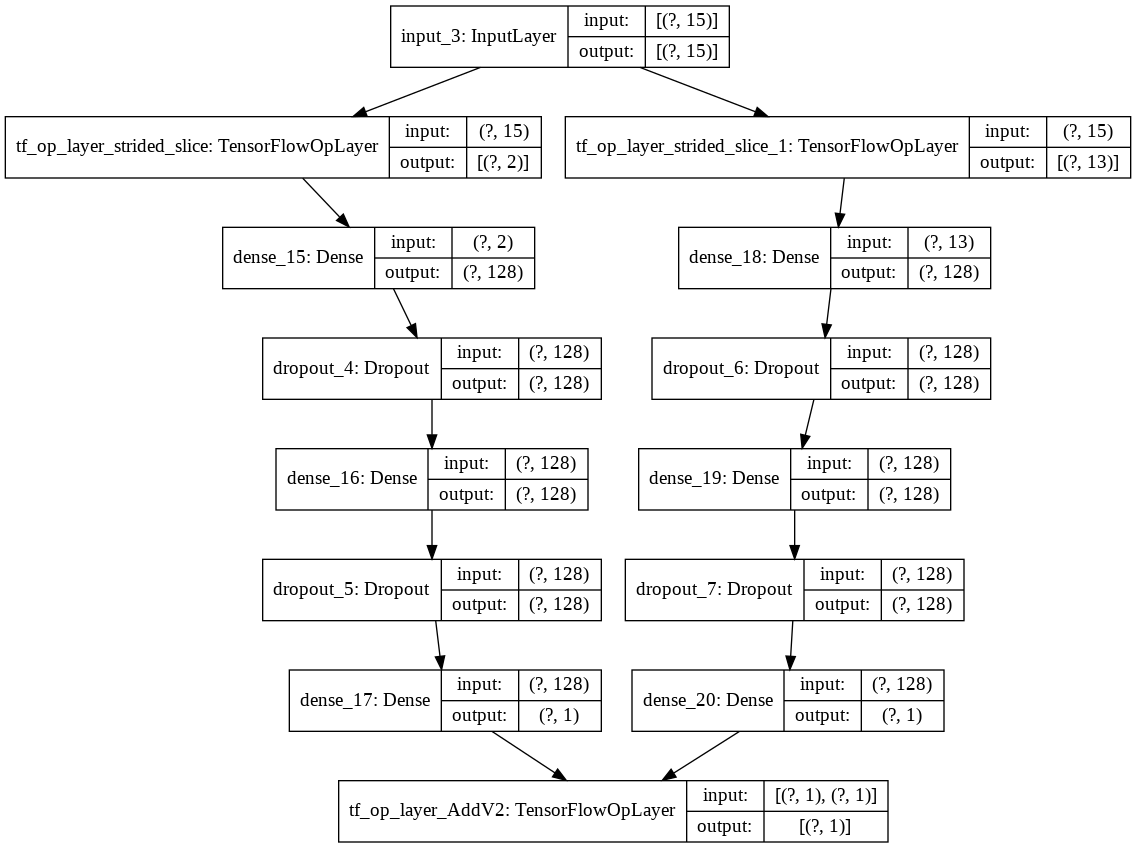

In [0]:
import tensorflow.keras as keras

keras.utils.plot_model(model_all, show_shapes=True)

In [0]:
history = train_dnn.train(model_all, X_train_scaled, y_train, X_test_scaled, y_test)

Epoch 1/1000
69/69 [==============================] - 0s 3ms/step - loss: 1.2811 - R_squared: -0.5000 - val_loss: 0.4158 - val_R_squared: 0.4600
Epoch 2/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.5000 - R_squared: 0.3938 - val_loss: 0.3709 - val_R_squared: 0.5172
Epoch 3/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4392 - R_squared: 0.4705 - val_loss: 0.3416 - val_R_squared: 0.5591
Epoch 4/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4042 - R_squared: 0.5195 - val_loss: 0.3301 - val_R_squared: 0.5729
Epoch 5/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4001 - R_squared: 0.5178 - val_loss: 0.3296 - val_R_squared: 0.5769
Epoch 6/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3630 - R_squared: 0.5654 - val_loss: 0.3239 - val_R_squared: 0.5827
Epoch 7/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3674 - R_squared: 0.5468 - val_loss: 0.3218 - val_R_squared

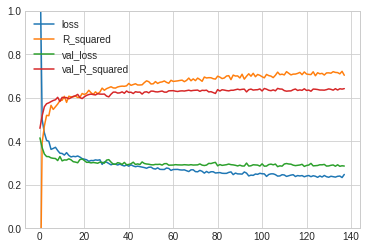

In [0]:
pd.DataFrame(history.history).plot(ylim=(0, 1), grid=True)

In [0]:
loc_DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model_all.predict(X_train_scaled).flatten()).numpy(),
    Test=tf_r2.R_squared(
        y_test, model_all.predict(X_test_scaled).flatten()).numpy())

pd.DataFrame([OLS_r2, DNN_r2, loc_DNN_r2], index=['OLS R2', 'DNN R2', 'loc DNN R2'])

Train      Test
OLS R2      0.601956  0.540067
DNN R2      0.725528  0.613290
loc DNN R2  0.751835  0.644565

In [0]:
location_predicted = loc_model.predict(scaler.transform(features)).flatten()

mapairbnb.plot(data, features, color_by=location_predicted,
               color_title='Diff log price', hover=False, zoom=8)